In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment-analysis-for-mental-health/Combined Data.csv
/kaggle/input/redditmh/processed_disorders.csv


In [2]:
from keras_hub.tokenizers import WordPieceTokenizer, compute_word_piece_vocabulary
import tensorflow as tf
import keras
from keras import layers, optimizers

# Data Processing

In [3]:
data = pd.read_csv("/kaggle/input/redditmh/processed_disorders.csv")
data.head()

,content,label
0,life is so pointless without others : does any...,bpd
1,cold rage : hello fellow friends \n\ni'm on th...,bpd
2,i dont know who i am : my f20 bf m20 told me t...,bpd
3,"help opinions advice : okay, im about to open ...",bpd
4,my ex got diagnosed with bpd : without going i...,bpd


In [4]:
data = data.rename(columns = {"content":"text"})
data

,text,label
0,life is so pointless without others : does any...,bpd
1,cold rage : hello fellow friends \n\ni'm on th...,bpd
2,i dont know who i am : my f20 bf m20 told me t...,bpd
3,"help opinions advice : okay, im about to open ...",bpd
4,my ex got diagnosed with bpd : without going i...,bpd
...,...,...
543055,jaw clenching : hey. i don't know if this is t...,schizophrenia
543056,is it safe to take appetite suppressants for w...,schizophrenia
543057,i'm worried i can't tell what side effects i a...,schizophrenia
543058,and the symptoms are back : was getting the sk...,schizophrenia


In [5]:
data['label'].unique()

array(['bpd', 'bipolar', 'depression', 'anxiety', 'schizophrenia'],
      dtype=object)

In [6]:
from sklearn.preprocessing import OrdinalEncoder
encode = OrdinalEncoder()
data['label'] = encode.fit_transform(data['label'].values.reshape(-1, 1)).astype(int)
data['label'].unique()

array([2, 1, 3, 0, 4])

In [7]:
data.isnull().any()

text     False
label    False
dtype: bool

In [8]:
data = data.dropna(axis = 0)
data

,text,label
0,life is so pointless without others : does any...,2
1,cold rage : hello fellow friends \n\ni'm on th...,2
2,i dont know who i am : my f20 bf m20 told me t...,2
3,"help opinions advice : okay, im about to open ...",2
4,my ex got diagnosed with bpd : without going i...,2
...,...,...
543055,jaw clenching : hey. i don't know if this is t...,4
543056,is it safe to take appetite suppressants for w...,4
543057,i'm worried i can't tell what side effects i a...,4
543058,and the symptoms are back : was getting the sk...,4


In [9]:
data.isnull().any()

text     False
label    False
dtype: bool

In [10]:
from sklearn.model_selection import train_test_split
train_df, other = train_test_split(
    data,
    test_size = 0.2,
    random_state = 9700,
    shuffle = True,
    stratify = data['label'],
)

In [11]:
val_df, test_df = train_test_split(
    other,
    test_size = 0.5,
    random_state = 9700,
    shuffle = True,
    stratify = other['label'],
)

In [12]:
len(train_df), len(val_df) ,len(test_df)

(434448, 54306, 54306)

In [15]:
train_dataset = tf.data.Dataset.from_tensor_slices(
        (train_df['text'].values, train_df['label'].values))
val_dataset = tf.data.Dataset.from_tensor_slices(
    (val_df['text'].values, val_df['label'].values)
)
test_dataset = tf.data.Dataset.from_tensor_slices(
    (test_df['text'].values, test_df['label'].values)
)

In [16]:
BATCH_SIZE = 64
MAX_SEQLEN = 512
auto = tf.data.AUTOTUNE

EMBED_DIM = 128
INTERMEDIATE_DIM = 4 * EMBED_DIM

In [17]:
# convert the text to lowercase
train_dataset = train_dataset.map(lambda text, label: (tf.strings.lower(text), label))
val_dataset = val_dataset.map(lambda text, label: (tf.strings.lower(text), label))
test_dataset = test_dataset.map(lambda text, label: (tf.strings.lower(text), label))

train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(auto)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(auto)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(auto)

In [18]:
for text_batch, label_batch in train_dataset.take(1):
    for i in range(3):
        print(f"{text_batch.numpy()[i]}\n{label_batch.numpy()[i]}\n")

b"i am other peoples trauma and i can't deal with it. : i saw someone today that i hadn't seen in 10 years. we knew each other in high school when my symptoms really started to show themselves. i saw her at the grocery store with her two kids and as soon as she saw me she left her buggy and bolted from the store. i don't think i'm the only person here who has done and said terrible things that they're ashamed of but i never thought i had, i don't know, such a strong effect. \n\n\n\nit's been 2 years since i was last ghosted by my fp, as y'all say, and i've been on my own since as i don't want to trust anyone anymore. this year has been particularly brutal with multiple people and animals around me dying under horrible circumstances. the levees finally broke and i hurt myself like a minute after making it back to the house. the shame of being 30 and cutting again combined with not being able to stop thinking about the fucked up things i did as a teen and the people i did them to is comp

In [19]:
reserved_tokens = ["[PAD]", "[UNK]"]

#Calculate Vocabulary Size
vocabulary = set()
train_df['text'].str.lower().str.split().apply(vocabulary.update)
vocabulary_size = len(vocabulary)
print(vocabulary_size)

414336


In [20]:
def train_word_piece(ds, vocab_size, reserved_tokens):
    word_piece_ds = ds.unbatch().map(lambda x, y: x)
    vocab = compute_word_piece_vocabulary(
        word_piece_ds.batch(1024).prefetch(2),
        vocabulary_size=vocabulary_size,
        reserved_tokens=reserved_tokens,
    )
    return vocab

In [21]:
vocab = train_word_piece(train_dataset, vocabulary_size, reserved_tokens)

In [22]:
tokenizer = WordPieceTokenizer(
    vocabulary = vocab,
    lowercase = False,
    sequence_length = MAX_SEQLEN,
)

In [23]:
input_sentence_ex = train_dataset.take(1).get_single_element()[0][0]
input_tokens_ex = tokenizer(input_sentence_ex)

print("Sentence: ", input_sentence_ex)
print("Tokens: ", input_tokens_ex)
print("Recovered text after detokenizing: ", tokenizer.detokenize(input_tokens_ex))

Sentence:  tf.Tensor(b"i am other peoples trauma and i can't deal with it. : i saw someone today that i hadn't seen in 10 years. we knew each other in high school when my symptoms really started to show themselves. i saw her at the grocery store with her two kids and as soon as she saw me she left her buggy and bolted from the store. i don't think i'm the only person here who has done and said terrible things that they're ashamed of but i never thought i had, i don't know, such a strong effect. \n\n\n\nit's been 2 years since i was last ghosted by my fp, as y'all say, and i've been on my own since as i don't want to trust anyone anymore. this year has been particularly brutal with multiple people and animals around me dying under horrible circumstances. the levees finally broke and i hurt myself like a minute after making it back to the house. the shame of being 30 and cutting again combined with not being able to stop thinking about the fucked up things i did as a teen and the people 

In [24]:
def format_dataset(sentence, label):
    sentence = tokenizer(sentence)
    return ({"input_ids": sentence}, label)

def make_dataset(dataset):
    dataset = dataset.map(format_dataset, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset.shuffle(BATCH_SIZE * 8).prefetch(16).cache()
train_dataset = make_dataset(train_dataset)
val_dataset = make_dataset(val_dataset)
test_dataset = make_dataset(test_dataset)

In [26]:
from keras_hub.layers import TokenAndPositionEmbedding, FNetEncoder
import keras_tuner as kt
from tensorflow.keras.layers import Lambda, Input, Dense, Bidirectional, LSTM
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.models import Model

def EmoAkinator(hp):
    input_ids = Input(shape=(None,), dtype="int64", name="input_ids")
    x = TokenAndPositionEmbedding(
        vocabulary_size=vocabulary_size,
        sequence_length=MAX_SEQLEN,
        embedding_dim=EMBED_DIM,
        mask_zero=False,
    )(input_ids)
    x = Bidirectional(
        LSTM(
            hp.Int("units1", min_value=32, max_value=256, step=32), 
            activation="tanh", 
            kernel_regularizer=regularizers.l2(0.001),
        )
    )(x)
    outputs = Dense(5, activation="sigmoid")(x)
    
    # Compile the model
    model = Model(input_ids, outputs, name="EmoAkinator4")
    model.compile(
        optimizer=optimizers.Adam(
            hp.Float("learning_rate", min_value=1e-4, max_value=5e-4, sampling="linear")
        ),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model


In [27]:
tuner = kt.BayesianOptimization(
    hypermodel = EmoAkinator,
    max_trials = 10,
    objective = "val_loss",
    overwrite = "True"
)
tuner.search(train_dataset, validation_data = val_dataset, epochs = 5, batch_size = 512, verbose = 1)

Trial 2 Complete [00h 59m 07s]
val_loss: 0.5043428540229797

Best val_loss So Far: 0.498735249042511
Total elapsed time: 01h 42m 03s

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
96                |128               |units1
0.0002639         |0.00032933        |learning_rate

Epoch 1/5
6789/6789 ━━━━━━━━━━━━━━━━━━━━ 473s 69ms/step - accuracy: 0.7060 - loss: 0.8611 - val_accuracy: 0.8136 - val_loss: 0.5446
Epoch 2/5
6789/6789 ━━━━━━━━━━━━━━━━━━━━ 471s 69ms/step - accuracy: 0.8244 - loss: 0.5168 - val_accuracy: 0.8274 - val_loss: 0.5106
Epoch 3/5
6789/6789 ━━━━━━━━━━━━━━━━━━━━ 469s 69ms/step - accuracy: 0.8377 - loss: 0.4802 - val_accuracy: 0.8276 - val_loss: 0.5155
Epoch 4/5
6789/6789 ━━━━━━━━━━━━━━━━━━━━ 468s 69ms/step - accuracy: 0.8471 - loss: 0.4523 - val_accuracy: 0.8275 - val_loss: 0.5115
Epoch 5/5
2146/6789 ━━━━━━━━━━━━━━━━━━━━ 5:10 67ms/step - accuracy: 0.8564 - loss: 0.4267

KeyboardInterrupt: 

In [30]:
best_model = tuner.get_best_models(num_models = 1)[0]
best_model.summary()
EmoAkinator4= best_model
EmoAkinator4.summary()

Model: "EmoAkinator4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_ids (InputLayer)               │ (None, None)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ token_and_position_embedding         │ (None, None, 128)           │      53,100,544 │
│ (TokenAndPositionEmbedding)          │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 256)                 │         263,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 53,364,997 (203.57 MB)

 Trainable params: 53,364,997 (203.57 MB)

 Non-trainable params: 0 (0.00 B)

Model: "EmoAkinator4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_ids (InputLayer)               │ (None, None)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ token_and_position_embedding         │ (None, None, 128)           │      53,100,544 │
│ (TokenAndPositionEmbedding)          │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 256)                 │         263,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 53,364,997 (203.57 MB)

 Trainable params: 53,364,997 (203.57 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
for inputs, targets in train_dataset.take(1):
    input_ids = inputs["input_ids"]
    break
embedding_layer = EmoAkinator4.layers[1]
mask = embedding_layer.compute_mask(input_ids)
print("Computed mask:", mask)

Computed mask: None


In [32]:
reduceLR = keras.callbacks.ReduceLROnPlateau(
    monitor = "val_loss",
    factor = 0.0973,
    patience = 3,
    verbose = 1,
    mode = "auto",
    min_delta = 1e-4,
    cooldown = 0,
    min_lr = 0,
)
earlyStop = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta = 0.001,
    patience = 10,
    verbose = 2,
    mode = "auto",
    restore_best_weights = True,
)
ck_point = keras.callbacks.ModelCheckpoint(filepath='best_model.keras', save_best_only=True, monitor='val_loss', mode='min', verbose = 1)
history = EmoAkinator4.fit(
    train_dataset,
    epochs=17, 
    validation_data=val_dataset,
    callbacks=[earlyStop, reduceLR, ck_point]
)

Epoch 1/17
 296/6789 ━━━━━━━━━━━━━━━━━━━━ 7:53 73ms/step - accuracy: 0.8410 - loss: 0.4688

KeyboardInterrupt: 

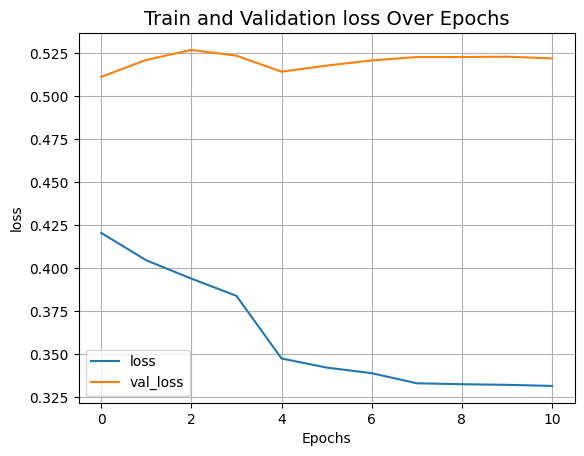

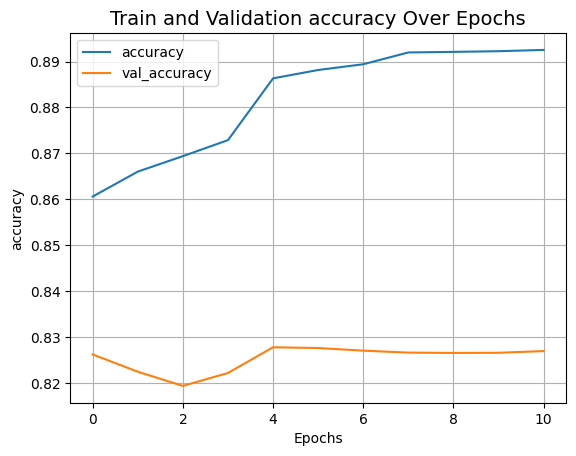

In [69]:
import matplotlib.pyplot as plt

def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("accuracy")

In [33]:
EmoAkinator4.evaluate(test_dataset)

849/849 ━━━━━━━━━━━━━━━━━━━━ 19s 20ms/step - accuracy: 0.8317 - loss: 0.4992


[0.49918919801712036, 0.8330571055412292]